In [1]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import yfinance as yf

In [15]:
class mc_option_pricer:
    def __init__(self, strike, risk_free, time, n_steps, ticker=None, sigma=None, current=None, dividend=None):
        self.strike = strike
        self.risk_free = risk_free
        self.time = time
        self.N = norm.cdf
        self.n_steps = n_steps

        if ticker:
            self.ticker = ticker
            self.real_data()
            if dividend is None:
                self.dividend = self.get_dividend_yield()
            else:
                self.dividend = dividend
        elif not current or not sigma:
            print("Input either a ticker or both volatility and current price")
            exit(0)
        else:
            self.sigma = sigma
            self.current = current
            self.dividend = dividend if dividend else 0.0
            
    
    def call(self):
        Z = np.random.standard_normal(self.n_steps)
        prices = self.current * np.exp((self.risk_free - self.dividend - 0.5 * self.sigma**2) * self.time + self.sigma * np.sqrt(self.time) * Z)
        payoffs = np.maximum(prices - self.strike,  0)
        
        return np.exp(-self.risk_free * self.time) * np.mean(payoffs)
        

    def put(self):
        Z = np.random.standard_normal(self.n_steps)
        prices = self.current * np.exp((self.risk_free - self.dividend - 0.5 * self.sigma**2) * self.time + self.sigma * np.sqrt(self.time) * Z)
        payoffs = np.maximum(self.strike - prices,  0)
        
        return np.exp(-self.risk_free * self.time) * np.mean(payoffs)
    
    def real_data(self):
        today = date.today()
        lookback = int(max(self.time * 252, 10))
        data = yf.download(self.ticker, start=today - timedelta(days=lookback * 2), end=today)
        closes = data['Adj Close']
        self.current = closes.iloc[-1]
        pct_change = closes.pct_change()
        self.sigma = pct_change.iloc[-lookback:].std() * np.sqrt(252)

    def get_dividend_yield(self):
        ticker_info = yf.Ticker(self.ticker).info
        if 'dividendYield' in ticker_info and ticker_info['dividendYield']:
            return ticker_info['dividendYield']
        return 0.0
    
    def plot_hm(self, contract):
        times = np.linspace(0.01, 1, 25)
        if contract == 'Call':
            strikes = np.linspace(self.current, self.current + 25, 25)
        else:
            strikes = np.linspace(self.current - 25, self.current, 25)

        prices = np.zeros((len(times), len(strikes)))
                
        for i, t in enumerate(reversed(times)):
            for j, k in enumerate(strikes):
                self.strike = k
                self.time = t
                
                if contract == 'Call':
                    prices[i, j] = self.call()
                else:
                    prices[i, j] = self.put()

        plt.figure(figsize=(6, 5))
        sns.heatmap(prices, cmap='viridis')
        ax = plt.gca()
        num_xticks = 10
        num_yticks = 10
        xtick_positions = np.linspace(0, len(strikes) - 1, num_xticks)
        ytick_positions = np.linspace(0, len(times) - 1, num_yticks)
        ax.set_xticks(xtick_positions)
        ax.set_yticks(ytick_positions)
        ax.set_xticklabels([f'{strikes[int(p)]:.1f}' for p in xtick_positions])
        ax.set_yticklabels([f'{times[int(-p - 1)]:.2f}' for p in ytick_positions])
        plt.xlabel('Strike Price ($)')
        plt.ylabel('Time to Expiry (years)')
        plt.title(f'Option Price Heatmap {contract}s')
        plt.tight_layout()
        plt.show()


[*********************100%%**********************]  1 of 1 completed


Call price in 20 trading days at $600 strike price: 8.171610366498674
Put price in 20 trading days at $590 strike price: 6.468927140120828


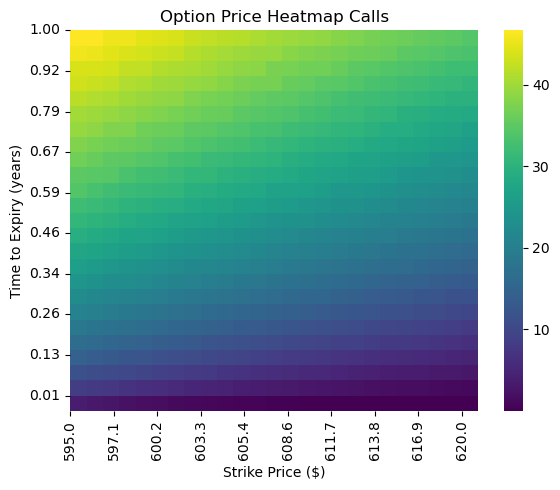

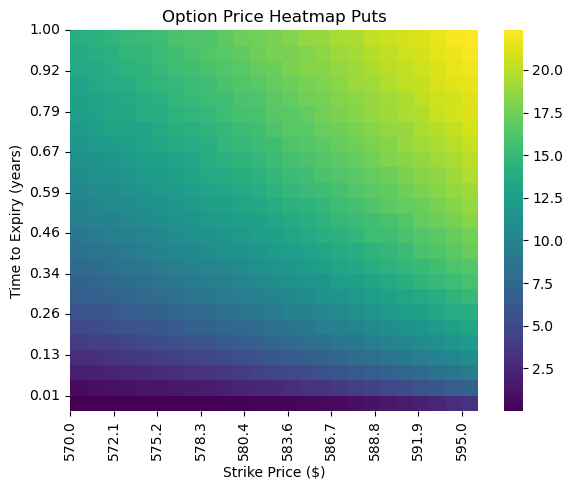

In [16]:
strike = 600
price = 0
volatility = 0
risk_free = .042
time = 20/252
n_steps = 100000
pricer = mc_option_pricer(strike, risk_free, time, n_steps, ticker = 'SPY')

print(f'Call price in 20 trading days at $600 strike price: {pricer.call()}')
pricer.strike = 590
print(f'Put price in 20 trading days at $590 strike price: {pricer.put()}')
pricer.plot_hm('Call')
pricer.plot_hm('Put')